# Lattice Path Integral Monte Carlo (PIMC)

In [38]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad

## Creating a random initial configuration of bosons

In [39]:
# Simulation parameters
N = 2
L = N*2   # half-filling
t = 0
U = 0.5
mu = -0.1
    
# PIMC parameters
beta = 1
eta = 1/np.sqrt(L*beta)      # worm end fugacity

alpha = pimc.random_boson_config(L,N)
alpha

array([1, 0, 1, 0])

## Data Structure
To store the worldline configurations, it will only be necessary to know for each site: i) the imaginary times at which kinks happened ii) the number of particles after the kink and iii) the direction of the kink. Python lists can be used to keep track of these.

In [3]:
alpha = pimc.random_boson_config(L,N)
print("\n | alpha > = ", alpha)

data_struct = pimc.create_data_struct(alpha)
print("\n Data Structure: ", data_struct)


 | alpha > =  [1 0 0 1]

 Data Structure:  [[[0, 1, (0, 0)]], [[0, 0, (1, 1)]], [[0, 0, (2, 2)]], [[0, 1, (3, 3)]]]


### Visualizing the data structure
The file 'view_worldlines.py' in this directory, contains a function of the same name that will generate a visualization of the worldline configurations. The view_worldlines function will take as an argument, the data structure and $\beta$. Optionally, the figure can be saved by giving including the desired filename, with the desired extensios, as a parameter.


| alpha > =  [1 0 0 1]


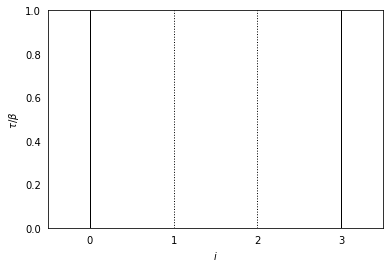

In [4]:
print("\n| alpha > = ", alpha)

beta = 1.0
pimc.view_worldlines(data_struct,beta,figure_name=None)

## Updates

Here we will illustrate the set of ergodic updates that will modify the data structure to generate new worldline configurations.

### Insert Worm

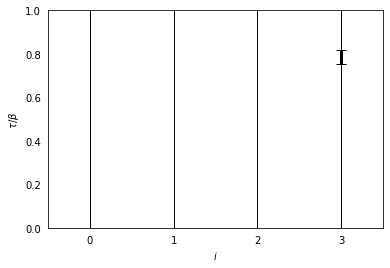

In [40]:
alpha = [1,1,1,1]
#alpha = [0,0,0,0]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.worm_insert(data_struct, beta, head_loc, tail_loc, U, mu, eta)
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Timeshift

In [ ]:
# Do a single timeshift
pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu)
pimc.view_worldlines(data_struct,beta,figure_name=None)
tau_1 = data_struct[head_loc[0]][head_loc[1]][0]
tau_2 = data_struct[tail_loc[0]][tail_loc[1]][0]
print("tau_head = %.8f"%(tau_1))
print("tau_tail = %.8f"%(tau_2))
print("worm_length = %.8f"%(abs(tau_1-tau_2)))

In [41]:
# Do timeshift many times on the above configuration
mc_steps = int(1E+05)
worm_lengths = np.zeros(mc_steps)  # create array to save worm lengths
accepted = 0
rejected = 0
for m in range(mc_steps):
    tau_1 = data_struct[head_loc[0]][head_loc[1]][0]
    tau_2 = data_struct[tail_loc[0]][tail_loc[1]][0]
    worm_length = abs(tau_1-tau_2)
    worm_lengths[m] = worm_length
        
    pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc, U, mu)
    
    # Count accepted updates  
    if tau_1 != data_struct[head_loc[0]][head_loc[1]][0] or (
       tau_2 != data_struct[tail_loc[0]][tail_loc[1]][0] ):
        accepted += 1

    # Count rejected updates  
    if tau_1 == data_struct[head_loc[0]][head_loc[1]][0] and (
       tau_2 == data_struct[tail_loc[0]][tail_loc[1]][0] ):
        rejected += 1

# Print the number of accepted time shifts
print("Accepted: %.4f %%"%(accepted/mc_steps*100))
print("Rejected: %.4f %%"%(rejected/mc_steps*100))

Accepted: 100.0000 %
Rejected: 0.0000 %


In [64]:
# Get the largest and smallest worm length
min_length = np.min(worm_lengths)
max_length = np.max(worm_lengths)

# Generating the bin edges
#bins = np.histogram_bin_edges(worm_lengths,bins=50)

# Histogram of wormlengths
loc = 0
b = 1
scale = 1/abs(U-mu)

x = np.linspace(-0.6+loc,loc+b+0.6,1000)

n, bins = np.histogram(worm_lengths, bins=60, density=1)
dtau = 0.5*(bins[:-1]+bins[1:])
pdf = truncexpon.pdf(dtau,b=b/scale,loc=loc,scale=scale)
n_loc = (1-dtau)/dtau
n_prime = n/n_loc
n_prime /= (np.sum(n_prime)*dtau)

print("n_loc:", n_loc)

#pdf_area = quad(n_prime,0,1)
#print("pdf area: ", pdf)
print("n_prime_area: ", np.sum(n_prime))
print("pdf_area: ", np.sum(pdf))

fig, ax = plt.subplots(1, 1)
ax.plot(dtau,n_prime,"o",label="n_prime")
ax.plot(dtau,pdf,label='pdf')
#ax.plot(dtau,n_loc,label='n_loc')
#ax.plot(dtau,n_loc/pdf/n,label='n_loc/pdf/n')
#ax.hist(worm_lengths,bins=bins,density=True,histtype='stepfilled',alpha=0.2) 
ax.set_xlabel(r"$\vert \tau_h - \tau_t \vert $") ;
#ax.set_yscale("log");
plt.legend()
plt.savefig("%d_%d_%.4f_%.4f_%.4f_%d.pdf"%(L,N,U,mu,t,mc_steps))

n_loc: [1.19474476e+02 3.91631991e+01 2.30985244e+01 1.62134169e+01
 1.23882932e+01 9.95409971e+00 8.26887800e+00 7.03304312e+00
 6.08798969e+00 5.34189290e+00 4.73790852e+00 4.23896404e+00
 3.81985007e+00 3.46282663e+00 3.15504748e+00 2.88698153e+00
 2.65140823e+00 2.44275746e+00 2.25666341e+00 2.08965583e+00
 1.93894161e+00 1.80224725e+00 1.67770345e+00 1.56375908e+00
 1.45911625e+00 1.36268067e+00 1.27352323e+00 1.19084994e+00
 1.11397827e+00 1.04231822e+00 9.75357169e-01 9.12647605e-01
 8.53797080e-01 7.98460009e-01 7.46330876e-01 6.97138587e-01
 6.50641760e-01 6.06624757e-01 5.64894345e-01 5.25276861e-01
 4.87615792e-01 4.51769710e-01 4.17610498e-01 3.85021821e-01
 3.53897801e-01 3.24141867e-01 2.95665756e-01 2.68388636e-01
 2.42236344e-01 2.17140708e-01 1.93038957e-01 1.69873194e-01
 1.47589935e-01 1.26139694e-01 1.05476616e-01 8.55581518e-02
 6.63447652e-02 4.77996692e-02 2.98885926e-02 1.25795680e-02]
n_prime_area:  2.0233631944096175
pdf_area:  60.066631590168825


TypeError: pdf() missing 1 required positional argument: 'x'